# Data Assessment - 2

#Project Title :- Breast Histopathology Images (Group :- 09)

# Introduction

A collection of high-resolution histology photographs of breast tissue samples with either benign or malignant labels may be found in the Breast Histology Images dataset on Kaggle. A total of 277,524 colour png photos with a 50*50 pixel resolution are included in the dataset. Each slide of the 162 histology slides used to create the photos had thousands of images.In this capstone project, Using convolutional neural networks (CNN) and OpenCV, we'll create a deep learning model for identifying breast cancer. we aim to provide a comprehensive overview of the process involved in loading data, processing it, and predicting results. Our focus will be on constructing a machine learning model that can effectively identify instances of malignant breast cancer within images.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
mkdir /content/dataset/

In [3]:
mkdir /content/dataset/initialPath

In [4]:
! unzip "gdrive/MyDrive/Colab Notebooks/Breast_Cancer_Classification/dataset/breast-histopathology-images" -d /content/dataset/initialPath

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/initialPath/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1551_class0.png  
  inflating: /content/dataset/initialPath/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1601_class0.png  
  inflating: /content/dataset/initialPath/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1651_class0.png  
  inflating: /content/dataset/initialPath/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1701_class0.png  
  inflating: /content/dataset/initialPath/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1751_class0.png  
  inflating: /content/dataset/initialPath/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1801_class0.png  
  inflating: /content/dataset/initialPath/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1851_class0.png  
  inflating: /content/dataset/initialPath/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1901_class0.png  
  inflating: /content/dataset/initialPath/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1951_class0.p

In [5]:
mkdir /content/dataset/finalPath

In [6]:
mkdir /content/output

In [7]:
mkdir /content/utils

In [8]:
cp 'gdrive/MyDrive/Colab Notebooks/Breast_Cancer_Classification/utils/config.py' '/content/utils/config.py'

In [9]:
cp 'gdrive/MyDrive/Colab Notebooks/Breast_Cancer_Classification/utils/conv_bc_model.py' '/content/utils/conv_bc_model.py'

In [10]:
cp 'gdrive/MyDrive/Colab Notebooks/Breast_Cancer_Classification/utils/create_dataset.py' '/content/utils/create_dataset.py'

In [11]:
cp 'gdrive/MyDrive/Colab Notebooks/Breast_Cancer_Classification/utils/getPaths.py' '/content/utils/getPaths.py'

#We will run the crete_dataset script to randomly shuffle the data and create the folders and files for training, testing, and validation.

In [12]:
! python /content/utils/create_dataset.py

555048
555048
Making 'training' split
'Creating /content/dataset/finalPath/training' directory
'creating /content/dataset/finalPath/training/1' directory
'creating /content/dataset/finalPath/training/0' directory
Making 'validation' split
'Creating /content/dataset/finalPath/validation' directory
'creating /content/dataset/finalPath/validation/1' directory
'creating /content/dataset/finalPath/validation/0' directory
Making 'testing' split
'Creating /content/dataset/finalPath/testing' directory
'creating /content/dataset/finalPath/testing/0' directory
'creating /content/dataset/finalPath/testing/1' directory


**Model Building and Evaluation**

In [13]:
# Setting the matplotlib backend so that if required then images can be saved in the background
import matplotlib
matplotlib.use("Agg")
%matplotlib inline

In [14]:
# import the packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from tensorflow.keras.optimizers import Adam
from utils import config
from utils.conv_bc_model import BC_Model
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import pandas as pd
import seaborn as sns
import cv2

In [15]:
# Defining a function for plotting the count of data against each class in each directory
def plotData(dirPath):
    # Get the path to the benign and malignant sub-directories
    benign_cases_dir = dirPath+ '/0/'
    malignant_cases_dir = dirPath + '/1/'

    # Get the list of all the images
    benign_cases = glob.glob(benign_cases_dir + '*.png')
    malignant_cases = glob.glob(malignant_cases_dir + '*.png')

    # An empty list. We will insert the data into this list in (img_path, label) format
    data1 = []

    # Go through all the benign cases. The label for these cases will be 0
    for img in benign_cases:
        data1.append((img,0))

    # Go through all the malignant cases. The label for these cases will be 1
    for img in malignant_cases:
        data1.append((img, 1))

    # Get a pandas dataframe from the data we have in our list 
    data1 = pd.DataFrame(data1, columns=['image', 'label'],index=None)

    # Shuffle the data 
    data1 = data1.sample(frac=1.).reset_index(drop=True)
    
    # Get the counts for each class
    cases_count = data1['label'].value_counts()
    print(cases_count)

    # Plot the results 
    plt.figure(figsize=(10,8))
    sns.barplot(x=cases_count.index, y= cases_count.values)
    plt.title('Number of cases', fontsize=14)
    plt.xlabel('Case type', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(range(len(cases_count.index)), ['benign(0)', 'malignant(1)'])
    plt.show()
    

0    183230
1     72631
Name: label, dtype: int64


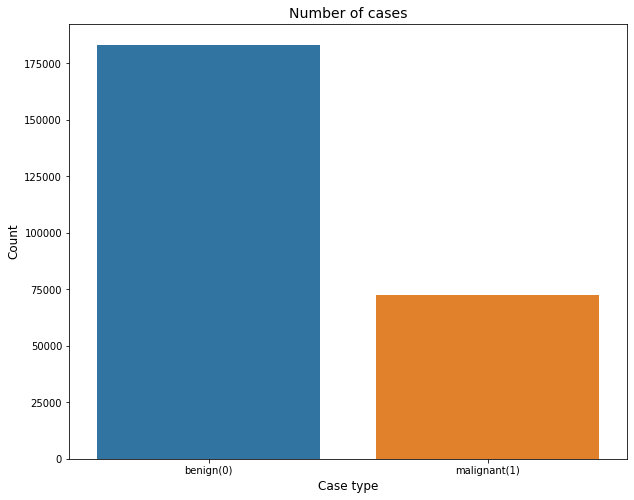

In [16]:
plotData(config.TRAIN_PATH)

0    71506
1    28436
Name: label, dtype: int64


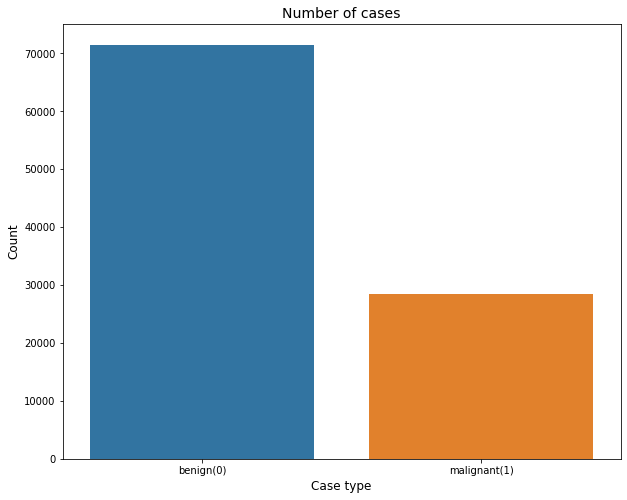

In [17]:
plotData(config.TEST_PATH)

0    30543
1    12134
Name: label, dtype: int64


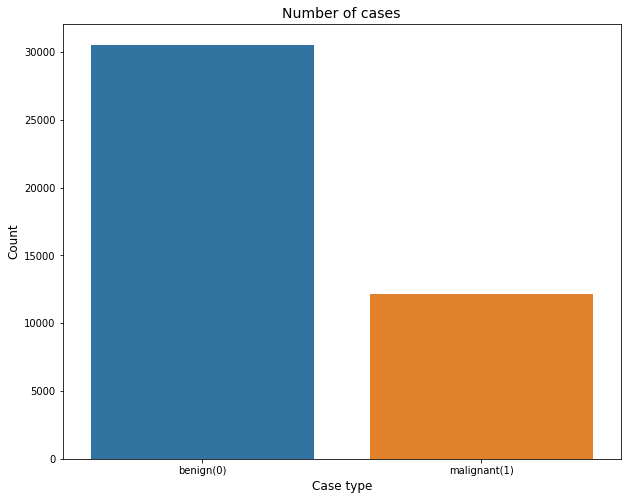

In [18]:
plotData(config.VAL_PATH)

In [19]:
# Get the path to the benign and malignant sub-directories
benign_cases_dir = config.TRAIN_PATH + '/0/'
malignant_cases_dir = config.TRAIN_PATH + '/1/'

# Get the list of all the images
benign_cases = glob.glob(benign_cases_dir + '*.png')
malignant_cases = glob.glob(malignant_cases_dir + '*.png')

#print (benign_cases)
#print(malignant_cases)
# An empty list. We will insert the data into this list in (img_path, label) format
train_data1 = []

# Go through all the benign cases. The label for these cases will be 0
for img in benign_cases:
    train_data1.append((img,0))

# Go through all the malignant cases. The label for these cases will be 1
for img in malignant_cases:
    train_data1.append((img, 1))

# Get a pandas dataframe from the data we have in our list 
train_data1 = pd.DataFrame(train_data1, columns=['image', 'label'],index=None)



#We created a dataframe called "train data1" that includes all of the extracted images, their labels, and corresponding dimensions. To better grasp the image dataset we have available, we'll take a look at it.

In [20]:
 train_data1.columns

Index(['image', 'label'], dtype='object')

In [23]:
train_data1.shape

(255861, 2)

In [24]:
train_data1.head

<bound method NDFrame.head of                                                     image  label
0       /content/dataset/finalPath/training/0/10291_id...      0
1       /content/dataset/finalPath/training/0/13022_id...      0
2       /content/dataset/finalPath/training/0/9322_idx...      0
3       /content/dataset/finalPath/training/0/13691_id...      0
4       /content/dataset/finalPath/training/0/10295_id...      0
...                                                   ...    ...
255856  /content/dataset/finalPath/training/1/15634_id...      1
255857  /content/dataset/finalPath/training/1/10279_id...      1
255858  /content/dataset/finalPath/training/1/10254_id...      1
255859  /content/dataset/finalPath/training/1/9250_idx...      1
255860  /content/dataset/finalPath/training/1/12949_id...      1

[255861 rows x 2 columns]>

#Checking the null value in dataframe

In [25]:
train_data1.isnull().sum()

image    0
label    0
dtype: int64

#Column specification

In [26]:
train_data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255861 entries, 0 to 255860
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   image   255861 non-null  object
 1   label   255861 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.9+ MB


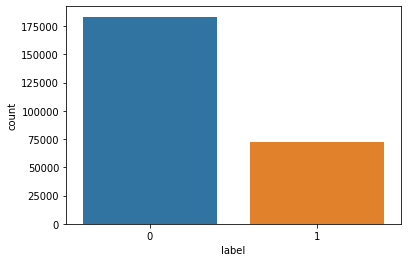

In [27]:
sns.countplot(x=train_data1['label'])

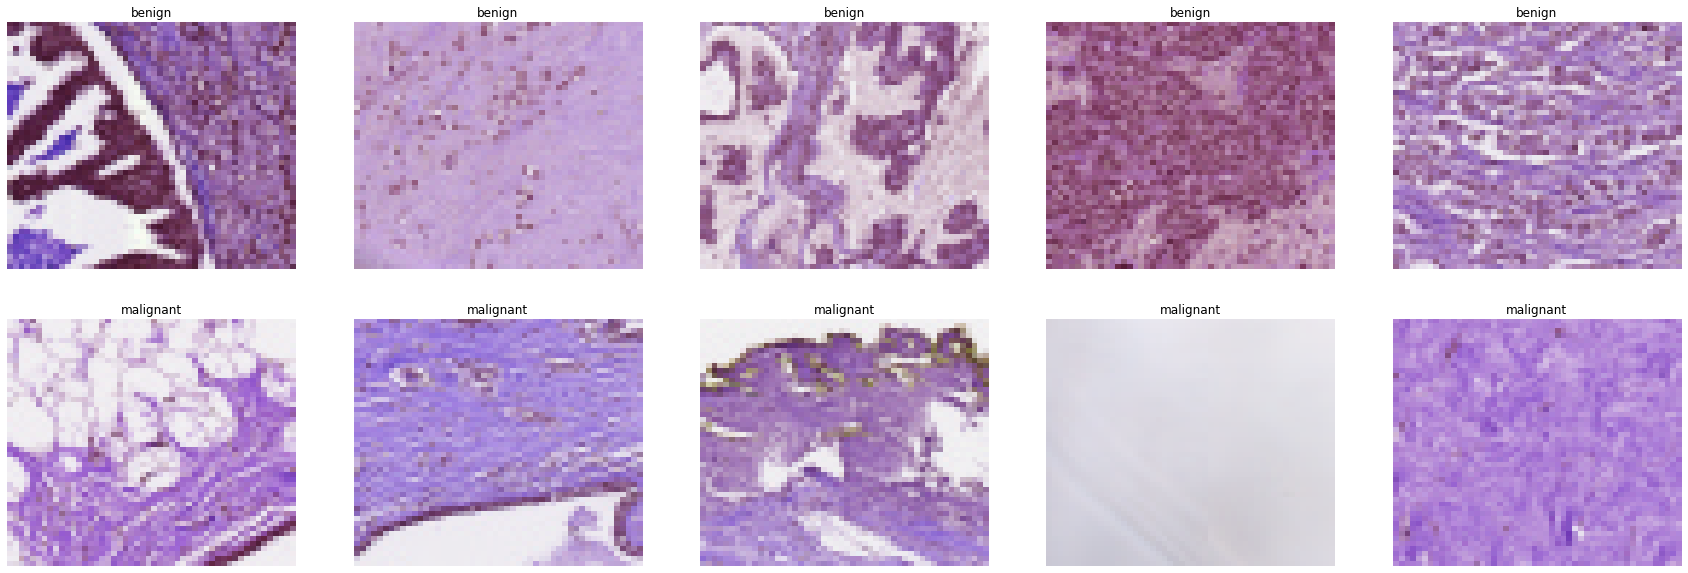

In [30]:
# Get few samples for both the classes
malignant_samples = (train_data1[train_data1['label']==1]['image'].iloc[:5]).tolist()
benign_samples = (train_data1[train_data1['label']==0]['image'].iloc[:5]).tolist()

# Concat the data in a single list and del the above two list
samples = malignant_samples + benign_samples
del malignant_samples, benign_samples

# Plot the data 
f, ax = plt.subplots(2,5, figsize=(30,10))
for i in range(10):
    img = cv2.imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("benign")
    else:
        ax[i//5, i%5].set_title("malignant")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

If we look carefully, then there are some cases where we won't be able to differentiate between a benign case and a malignant case with the naked eye. If we can build a robust classifier, it would be a great assist for the doctor too.

In [31]:
# Defining a method to get the number of files given a path
def retrieveNumberOfFiles(path):
    list1 = []
    for file_name in glob.iglob(path+'/**/*.png', recursive=True):
        list1.append(file_name)
    return len(list1)

In [32]:
# Defining a method to plot training and validation accuracy and loss
def training_plot(H, N, plotPath):
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    plt.savefig(plotPath)

In [33]:
# Defining the paths to the training, validation, and testing directories
trainPath = config.TRAIN_PATH
valPath = config.VAL_PATH
testPath = config.TEST_PATH

In [34]:
# Checking for the total number of image paths in training, validation and testing directories
totalTrain = retrieveNumberOfFiles(config.TRAIN_PATH)
totalVal = retrieveNumberOfFiles(config.VAL_PATH)
totalTest = retrieveNumberOfFiles(config.TEST_PATH)

In [35]:
# Defining a method to get the list of files given a path
def getAllFiles(path):
    list1 = []
    for file_name in glob.iglob(path+'/**/*.png', recursive=True):
        list1.append(file_name)
    return list1

In [36]:
# Retrieving all files from train directory
allTrainFiles = getAllFiles(config.TRAIN_PATH)

In [37]:
# Calculating the total number of training images against each class and then store the class weights in a dictionary
trainLabels = [int(p.split(os.path.sep)[-2]) for p in allTrainFiles]
trainLabels = to_categorical(trainLabels)
classSumTotals = trainLabels.sum(axis=0)
classWeight = dict()

# Looping over all classes and calculate the class weights
for i in range(0, len(classSumTotals)):
    classWeight[i] = classSumTotals.max() / classSumTotals[i]

In [38]:
# Initialize the training data augmentation object
## preprocess_input will scale input pixels between -1 and 1
## rotation_range is a value in degrees (0-180), a range within which to randomly rotate pictures
## zoom_range is for randomly zooming inside pictures
## width_shift and height_shift are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally
## shear_range is for randomly applying shearing transformations
## horizontal_flip and vertical_flip is for randomly flipping half of the images horizontally and vertically resp
## fill_mode is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift

trainAug = ImageDataGenerator(
	rescale=1 / 255.0,
	rotation_range=30,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	vertical_flip=True,
	fill_mode="nearest")

In [39]:
# Initialize the validation data augmentation object
valAug = ImageDataGenerator(rescale=1/255.0)

In [40]:
# Initialize the training generator
trainGen = trainAug.flow_from_directory(
	trainPath,
	class_mode="categorical",
	target_size=(48, 48),
	color_mode="rgb",
	shuffle=True,
	batch_size=config.BATCH_SIZE)

Found 255861 images belonging to 2 classes.


In [41]:
# Initialize the validation generator
valGen = valAug.flow_from_directory(
	valPath,
	class_mode="categorical",
	target_size=(48, 48),
	color_mode="rgb",
	shuffle=False,
	batch_size=config.BATCH_SIZE)

Found 42677 images belonging to 2 classes.


In [42]:
# Initialize the testing generator
testGen = valAug.flow_from_directory(
	testPath,
	class_mode="categorical",
	target_size=(48, 48),
	color_mode="rgb",
	shuffle=False,
	batch_size=config.BATCH_SIZE)

Found 99942 images belonging to 2 classes.


# **Data fitness for answering research questions**

**(I) Which machine learning classification algorithm works the best for diagnosing Breast Cancer using medical data of patients(images)?**

As in our dataset we are using CNN model and RestNet50 we trying to solve the problem with this networks. The ability of convolutional neural networks (CNNs) to automatically learn hierarchical characteristics from images makes them a popular choice for medical image analysis, particularly the diagnosis of breast cancer. Several performance indicators, including accuracy, precision, sensitivity, F1 score, ROC Curve-AUC Score, and log loss, can be used to assess a CNN's performance in detecting breast cancer using medical data.



# **Ethical Assessment for data collection and usage**

**Data Science Ethics Checklist**

# **A. Data Collection:**Data collecting ethics should take bias, privacy, informed permission, confidentiality, security, and other factors into account.

**A.1 Informed consent:** If there are human subjects, have they given informed consent, where subjects affirmatively opt-in and have a clear understanding of the data uses to which they consent?

**Breast Histopathology Images must have taken into account this ethical issue as they obtained the images from the sources. While extracting the pictures, we did not retrieve any private information, and the intended use is also extremely obvious.**

**A.2 Collection bias:** Have we considered sources of bias that could be introduced during data collection and survey design and taken steps to mitigate those?
**The breast cancer images have been collected as a part of the open source of Kaggle, the Breast Histopathology Images. Although we were worried about bias in picture extraction, we did not find several essential details such patient age, gender, and medical history. However, we made sure to gather a comparable amount of photos for both the positive (1) and negative (0) patches.**

**A.3 Limit PII exposure:** Have we considered ways to minimize exposure of personally identifiable information (PII) for example through anonymization or not collecting information that isn't relevant for analysis?

**The dataset does not reveal any personally identifying information. In fact all of the patient's case, age, and gender values are missing from the photographs that Kaggle gathered. The picture extraction procedure, however, fully complied with data providers' requests for privacy and anonymity by collecting only the photographs and their medical case—IDC(-) image patches and IDC(+) image patches and  do not have  any type of personal information.**

**A.4 Downstream bias mitigation:**
Have we considered ways to enable testing downstream results for biased outcomes (e.g., collecting data on protected group status like race or gender)?

**There are no personally identifiable details in the dataset. In actuality, none of the patient's case, age, or gender values can be seen in the images.**


# **B.Data Storage**

**B.1 Data security:** Do we have a plan to protect and secure data (e.g., encryption at rest and in transit, access controls on internal users and third parties, access logs, and up-to-date software)?
**The group is aware of how crucial it is to handle the images that were retrieved with care for the purposes of this research. The team members will ensure that only the five other members of the group have access to or utilise the data by keeping access restricted to themselves only. Additionally, the images will be kept on Google Drive with access limited to the team.**

**B.2 Right to be forgotten:** Do we have a mechanism through which an individual can request their personal information be removed?

**There is not any personal information in the dataset that can harm anyone's privacy.**

**B.3 Data retention plan:**Is there a schedule or plan to delete the data after it is no longer needed?

**Definitely, we will remove each and everything about the data once our project is done.**
